In [1]:
from sklearn.model_selection import GroupKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_enrich = pd.read_csv('../data/enriched_nba_player_data.csv')
df_raw = pd.read_csv('../data/historic_nba_player_data.csv')
df_enrich

,Season,Player,MP,PTS,AST,TRB,STL,BLK,TS%,PER,WS,BPM,VORP,USG%,W/L%,VORP_W/L,Share
0,2003,Tracy McGrady,1.752518,3.906772,1.976588,0.989477,2.029217,0.547788,1.094251,3.679828,3.819312,3.533756,5.219498,3.400096,0.512,4.542465,0.359
1,2003,Kobe Bryant,1.989500,3.547491,2.208540,1.160492,3.127797,0.547788,0.822543,2.769521,3.455285,2.480413,4.230047,2.923437,0.610,4.473849,0.417
2,2003,Allen Iverson,2.102348,3.136883,1.976588,0.006143,4.226377,-0.554120,-0.147845,1.659390,1.726161,1.365108,2.436666,2.923437,0.585,2.467411,0.070
3,2003,Shaquille O'Neal,1.571961,3.119774,0.584878,2.956146,-0.387660,3.486209,1.831746,3.502207,2.939582,2.294529,2.869551,2.363881,0.610,3.048417,0.106
4,2003,Paul Pierce,1.729949,2.846035,1.338721,1.331507,2.248933,0.547788,0.473203,1.992429,1.999180,1.798838,2.807710,2.985610,0.537,2.564918,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9264,2025,John Konchar,-1.395727,-1.304718,-0.850703,-0.383064,-0.204874,-0.408694,0.377048,-0.469053,-0.463602,0.790282,-0.127939,-1.964855,0.585,-0.129821,0.000
9265,2025,Miles Norris,-1.448642,-1.320769,-1.343209,-0.513075,-0.204874,-0.408694,-3.342469,-1.300337,-1.038213,-0.378206,-0.515632,-1.163180,0.744,-0.497531,0.000
9266,2025,Dwight Powell,-1.673532,-1.352871,-0.795980,-0.903111,-1.249105,-0.168899,2.268063,-0.284323,-0.386988,0.238496,-0.283016,-2.037734,0.476,-0.318013,0.000
9267,2025,Jericho Sims,-1.422184,-1.401025,-1.014872,-0.209715,-1.510163,-0.168899,1.111574,-0.953968,-0.540217,-0.735245,-0.670709,-2.037734,0.500,-0.623244,0.000


- This model will be a hybrid model, first classifying if the player will get votes, then predicting how much vote share they get, with the final prediction being a product of the results
- The baseline is a prediction of zero for every player, since most players get zero vote share

In [3]:
train = df_enrich[df_enrich['Season'] < 2025].copy()
test = df_enrich[df_enrich['Season'] == 2025].copy()

In [4]:
train['has_votes'] = (train['Share'] > 0).astype(int)

In [5]:
X = train[['MP', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'TS%', 'PER', 'WS', 'BPM', 'VORP', 'USG%', 'W/L%', 'VORP_W/L']]

y_vote = train['has_votes']
y_share = train['Share']

X_train, X_test, y_train_vote, y_test_vote, y_train_share, y_test_share = train_test_split(X, y_vote, y_share, test_size=0.2, 
                                                                                           random_state=69, stratify=y_vote)

In [6]:
pipe_class = Pipeline([
    ('Scaler', StandardScaler()),
    ('Logistic', LogisticRegression(penalty='l1', C=1.0, solver='liblinear'))
])

In [7]:
pipe_class.fit(X_train, y_train_vote)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('Logistic',
                 LogisticRegression(penalty='l1', solver='liblinear'))])

In [8]:
train_pred_vote = pipe_class.predict(X_train)
test_pred_vote = pipe_class.predict(X_test)
base = np.zeros(len(test_pred_vote))

mae_train = mean_absolute_error(y_train_vote, train_pred_vote)
mae_test = mean_absolute_error(y_test_vote, test_pred_vote)
baseline_vote = mean_absolute_error(y_test_vote, base)

print("Train MAE:", mae_train)
print("Test MAE:", mae_test)
print("Baseline MAE:", baseline_vote)

Train MAE: 0.013339009507591882
Test MAE: 0.014188422247446084
Baseline MAE: 0.03348467650397276


In [9]:
pipe_regr = Pipeline([
    ('Scaler', StandardScaler()),
    ('Poly', PolynomialFeatures(degree=2)),
    ('Ridge', Ridge(alpha=0.1))
])

In [10]:
pipe_regr.fit(X_train, y_train_share)

Pipeline(steps=[('Scaler', StandardScaler()), ('Poly', PolynomialFeatures()),
                ('Ridge', Ridge(alpha=0.1))])

In [11]:
train_pred_share = pipe_regr.predict(X_train)
test_pred_share = pipe_regr.predict(X_test)
#Set negative values to 0
test_pred_share = np.clip(test_pred_share, a_min=0, a_max=None)
base = np.zeros(len(test_pred_share))

mae_train = mean_absolute_error(y_train_share, train_pred_share)
mae_test = mean_absolute_error(y_test_share, test_pred_share)
baseline = mean_absolute_error(y_test_share, base)

print("Train MAE:", mae_train)
print("Test MAE:", mae_test)
print("Baseline MAE:", baseline)
print("r2_score:", r2_score(y_test_share, test_pred_share))

Train MAE: 0.010810524668465599
Test MAE: 0.0068315954244818995
Baseline MAE: 0.005969353007945517
r2_score: 0.7968733204916822


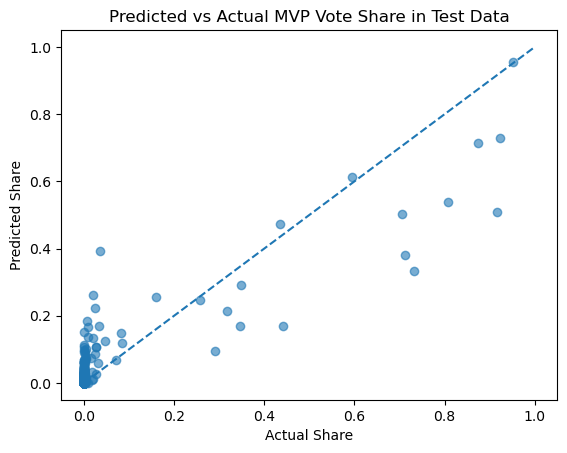

In [24]:
plt.scatter(y_test_share, test_pred_share, alpha=0.6)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Actual Share")
plt.ylabel("Predicted Share")
plt.title("Predicted vs Actual MVP Vote Share in Test Data")
plt.show()

In [13]:
test_pred = test_pred_share * test_pred_vote
base = np.zeros(len(test_pred))

mae_test = mean_absolute_error(y_test_share, test_pred)
baseline = mean_absolute_error(y_test_share, base)

print("Test MAE:", mae_test)
print("Baseline MAE:", baseline)
print("r2_score:", r2_score(y_test_share, test_pred))

Test MAE: 0.0035112201199261157
Baseline MAE: 0.005969353007945517
r2_score: 0.8155539291408208


In [14]:
train.loc[X_test.index, 'pred_share'] = test_pred_share
train.loc[X_test.index, 'pred_votes'] = test_pred_vote
train.loc[X_test.index, 'yhat'] = test_pred

In [15]:
df_val = train.dropna().sort_values(by=['yhat','pred_votes', 'Share', 'PTS'], ascending=False)
df_val[df_val['Season'] == 2007]

,Season,Player,MP,PTS,AST,TRB,STL,BLK,TS%,PER,...,BPM,VORP,USG%,W/L%,VORP_W/L,Share,has_votes,pred_share,pred_votes,yhat
1475,2007,Tracy McGrady,1.313379,2.441217,2.345457,0.493796,1.375970,0.081933,-0.301791,2.063118,...,2.371379,2.948421,3.268434,0.634,3.218556,0.085,1,0.118320,1.0,0.11832
1465,2007,Gilbert Arenas,1.768278,3.070463,2.077721,0.208044,2.825130,-0.486382,0.628493,2.239936,...,1.885496,2.812565,2.536176,0.500,2.308800,0.024,1,0.087110,1.0,0.08711
1487,2007,Baron Davis,1.256517,1.696056,3.202212,0.126401,3.308183,0.081933,-0.022706,1.576869,...,1.503731,1.589857,1.539491,0.512,1.325058,0.001,1,0.008792,0.0,0.00000
1498,2007,Tony Parker,0.938088,1.447669,1.809985,-0.363459,0.892917,-0.675821,0.758733,1.665278,...,1.330202,1.589857,1.722556,0.707,2.037517,0.001,1,0.044075,0.0,0.00000
1495,2007,Luol Deng,1.506711,1.480787,0.203568,1.228586,1.134443,0.271372,0.535465,1.068518,...,1.295496,2.065355,0.664849,0.598,2.117212,0.000,0,0.000000,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801,2007,Anthony Carter,-0.654058,-1.135555,1.809985,-1.057428,-1.763876,0.081933,-2.906588,-2.335226,...,-2.383330,-0.651774,-0.555582,0.549,-0.608288,0.000,0,0.021684,0.0,0.00000
1809,2007,C.J. Miles,-1.609345,-1.185232,-0.760282,-1.302358,-1.039296,-0.675821,-2.441446,-2.445737,...,-2.279212,-0.923487,-0.087750,0.622,-0.900693,0.000,0,0.000000,0.0,0.00000
1816,2007,Jake Tsakalidis,-1.529738,-1.251469,-1.081565,-0.485924,-1.280823,-0.296944,-1.120442,-1.208012,...,-1.585094,-0.787630,-1.165797,0.500,-0.716870,0.000,0,0.002591,0.0,0.00000
1818,2007,Jason Collins,-0.130924,-1.284587,-0.813829,-0.036886,-0.556243,0.081933,-2.292601,-2.401532,...,-1.758623,-1.806554,-2.406568,0.500,-1.573191,0.000,0,0.000000,0.0,0.00000


In [21]:
df_2025 = df_enrich[df_enrich['Season'] == 2025].copy()
X_2025 = df_2025[['MP', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'TS%', 'PER', 'WS', 'BPM', 'VORP', 'USG%', 'W/L%', 'VORP_W/L']]

scaler = StandardScaler()
scaler.fit(X_2025)
X_2025 = scaler.transform(X_2025)

pred_2025 = df_2025.copy()
pred_2025['pred_vote'] = pipe_class.predict(X_2025)
pred_2025['pred_share'] = np.clip(pipe_regr.predict(X_2025), a_min=0, a_max=None)
pred_2025['yhat'] = pred_2025['pred_vote'] * pred_2025['pred_share']
pred_2025.sort_values(by=['yhat', 'Share', 'pred_share', 'pred_vote'], ascending=False).head(30)

D:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,Season,Player,MP,PTS,AST,TRB,STL,BLK,TS%,PER,WS,BPM,VORP,USG%,W/L%,VORP_W/L,Share,pred_vote,pred_share,yhat
8809,2025,Shai Gilgeous-Alexander,1.527842,3.558794,2.159056,0.353670,2.405706,1.269869,1.080318,3.825913,5.359116,3.971168,6.385304,2.918071,0.829,8.777701,0.913,1,1.230174,1.230174
8811,2025,Nikola Jokić,1.858563,3.061207,4.238527,3.690638,2.666764,0.310691,1.486652,4.126099,5.244194,4.555412,7.083151,1.952418,0.610,7.017593,0.787,1,0.584420,0.584420
8810,2025,Giannis Antetokounmpo,1.527842,3.189616,2.213779,3.343940,0.317242,1.749459,0.892779,3.779731,3.367133,3.322007,4.601916,2.990951,0.585,4.356249,0.470,1,0.257036,0.257036
8814,2025,Jayson Tatum,1.818876,2.611773,1.940165,1.957148,0.839358,0.070896,0.220766,1.747704,2.600986,1.926313,3.206221,2.262156,0.744,3.991932,0.311,1,0.144497,0.144497
9061,2025,Cason Wallace,0.654740,-0.341646,0.024863,-0.339726,2.666764,0.070896,-0.091799,-0.422870,0.953770,0.563076,0.647447,-1.090301,0.829,1.065710,0.000,1,0.087198,0.087198
8813,2025,Anthony Edwards,1.805647,2.740183,1.119321,0.657030,1.100416,0.310691,0.423933,1.378244,2.179605,1.634190,3.051144,2.298595,0.598,2.960583,0.012,1,0.076378,0.076378
8870,2025,Tyrese Haliburton,1.448469,1.295575,3.691298,-0.296389,1.622532,0.550485,0.752125,1.770795,2.945752,2.121061,3.283760,0.513048,0.610,3.260031,0.000,1,0.073709,0.073709
8827,2025,LeBron James,1.620444,2.226545,3.144069,1.567113,0.578300,0.310691,0.564587,1.978616,1.911454,2.056145,3.128683,2.061737,0.610,3.106661,0.016,1,0.065671,0.065671
8839,2025,James Harden,1.673359,1.969726,3.417683,0.700368,1.883590,0.550485,0.220766,1.355153,2.141298,1.634190,2.896067,1.970638,0.610,2.876606,0.001,1,0.063774,0.063774
8926,2025,Jarrett Allen,0.707655,0.476965,-0.303474,2.390521,0.317242,1.030075,2.439973,1.840069,3.405441,1.601732,2.275758,-0.525485,0.780,3.032490,0.000,1,0.061615,0.061615


In [22]:
base = np.zeros(len(pred_2025))

mae_test = mean_absolute_error(pred_2025['yhat'], pred_2025['Share'])
mse_test = mean_squared_error(pred_2025['yhat'], pred_2025['Share'])
baseline = mean_absolute_error(base, pred_2025['Share'])

print("Test MAE:", mae_test)
print("Test MSE:", mse_test)
print("Baseline MAE:", baseline)
print("R2 score:", r2_score(pred_2025['Share'], pred_2025['yhat']))

Test MAE: 0.003550482355469238
Test MSE: 0.0005516606829494539
Baseline MAE: 0.005652173913043478
R2 score: 0.8559706542067977


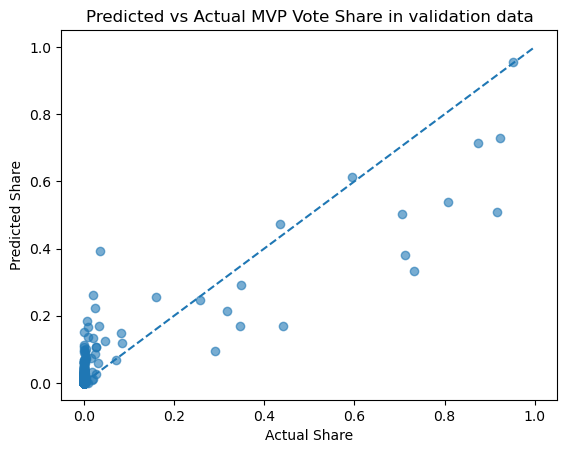

In [23]:
plt.scatter(df_val['Share'], df_val['pred_share'], alpha=0.6)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Actual Share")
plt.ylabel("Predicted Share")
plt.title("Predicted vs Actual MVP Vote Share in validation data")
plt.show()

Notes:
- Linear model performs well on unseen test data, with an MAE of 0.0032, Test MSE of  0.00056 and an r2 score of 0.85
- Some values are above a 1 which is not seen in the training data
- The model seems to predict higher values at lower vote shares and predict lower values at higher vote shares